## a. Introduction:

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Earlier, in the DATA CLEANING and EDA Notebook, we looked at how we can clean an NLP DATASET. Well in this section, we will be taking a look at how you can model such a dataset . We will be fine tuning two models:

- RoBerTa
- DistillBeRT from HuggingFace.

Note all these models can be found on HuggingFace.

Also, the dataset we will be using has already be cleaned. Therefore, you might have to check out the cleaning data set on hwo that was done

## b.Dependencies

### i. Installations

> Indented block



In [70]:
%%capture
!pip install transformers
!pip install accelerate -U
!pip install datasets
!pip install huggingface_hub



### Dependencies Importations

In [71]:
##for handling path of my datasets
import os
from google.colab import drive

##for data handling:

import pandas as pd
import numpy as np

##for visuals-- just in case

import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from transformers import TrainingArguments
from scipy.special import softmax
from torch import nn
import torch
from transformers import Trainer

##modelling:

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import transformers
from transformers import pipeline
from datasets import load_dataset
import nltk
nltk.download('punkt')
##others
import warnings
warnings.filterwarnings("ignore")
import os
os.environ["WANDB_DISABLED"] = "true"
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## c. Importing dataset from my Google Drive

In [72]:
data_path= '/content/drive/MyDrive/deep-learning/clean_copy.csv'

In [73]:
data= pd.read_csv(data_path)

In [74]:
data.head()

,Unnamed: 0,clean_tweet,label,agreement
0,0,amp big homie meanboy stegman st,0.0,1.0
1,1,im thinking devoting career proving autism isn...,1.0,1.0
2,2,vaccines vaccinate child,-1.0,1.0
3,3,mean immunize kid something wont secretly kill...,-1.0,1.0
4,4,thanks catch performing la nuit nyc st ave sho...,0.0,1.0


## c.Splitting Dataset

###i.creating a categorical mapping

In [75]:
data.head()

,Unnamed: 0,clean_tweet,label,agreement
0,0,amp big homie meanboy stegman st,0.0,1.0
1,1,im thinking devoting career proving autism isn...,1.0,1.0
2,2,vaccines vaccinate child,-1.0,1.0
3,3,mean immunize kid something wont secretly kill...,-1.0,1.0
4,4,thanks catch performing la nuit nyc st ave sho...,0.0,1.0


In [76]:
data= data.dropna()
data= data.drop("Unnamed: 0", axis=1)

In [77]:
##before splitting I will convert each tweet row to a tuple since that't the acceptable format

data['clean_tweet'] = data['clean_tweet'].apply(lambda tweet: tuple(tweet.split(),))




In [78]:
data.head()

,clean_tweet,label,agreement
0,"(amp, big, homie, meanboy, stegman, st)",0.0,1.0
1,"(im, thinking, devoting, career, proving, auti...",1.0,1.0
2,"(vaccines, vaccinate, child)",-1.0,1.0
3,"(mean, immunize, kid, something, wont, secretl...",-1.0,1.0
4,"(thanks, catch, performing, la, nuit, nyc, st,...",0.0,1.0


### ii.Data Splitting


In [79]:
train_set, eval_set= train_test_split(data, test_size= 0.2, stratify= data["label"], random_state= 42)

In [80]:

train_set.to_csv("/content/train_set.csv")
eval_set.to_csv("/content/eval_set.csv")

### iii.Loading the Dataset

In [81]:
dataset= load_dataset( "csv", data_files= { "train_set":"train_set.csv", "eval_set":"eval_set.csv"}                     )

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train_set split: 0 examples [00:00, ? examples/s]

Generating eval_set split: 0 examples [00:00, ? examples/s]

In [82]:
dataset

DatasetDict({
    train_set: Dataset({
        features: ['Unnamed: 0', 'clean_tweet', 'label', 'agreement'],
        num_rows: 7976
    })
    eval_set: Dataset({
        features: ['Unnamed: 0', 'clean_tweet', 'label', 'agreement'],
        num_rows: 1994
    })
})

##.C. Tokenization

In [83]:
distil= "distilbert-base-uncased"

In [84]:
distil_tokenizer= AutoTokenizer.from_pretrained(distil)

In [85]:
data["clean_tweet"].head()

0              (amp, big, homie, meanboy, stegman, st)
1    (im, thinking, devoting, career, proving, auti...
2                         (vaccines, vaccinate, child)
3    (mean, immunize, kid, something, wont, secretl...
4    (thanks, catch, performing, la, nuit, nyc, st,...
Name: clean_tweet, dtype: object

In [86]:
## our labels are-1, 0, 1 and we will like to transform them into 0,1,2 respectively

def transform_labels(input):
  label= input["label"]
  num =0

  if label== -1:
    num= 0
  elif label== 0:
    num =1
  elif label == 1:
    num = 2
  return {"label": num}

def distil_tokenize(example):
  return distil_tokenizer(example["clean_tweet"], padding= "max_length", truncation=True)


In [87]:
## removing unwanted features to keep only relevant features

dataset= dataset.map(distil_tokenize, batched= True)
remove_columns= ['Unnamed: 0', 'clean_tweet', 'label', 'agreement']
dataset = dataset.map(transform_labels, remove_columns=remove_columns)

Map:   0%|          | 0/7976 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Map:   0%|          | 0/7976 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

In [88]:
dataset

DatasetDict({
    train_set: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 7976
    })
    eval_set: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 1994
    })
})

###d. Dealing with Imbalance Class 0

From our EDA, we realized the -1 class (now our 0 class)  was imbalaned so we will deal with that in this section



In [89]:
##we are going to use our data dataset

class_weights= (1-(data["label"].value_counts().sort_index() /len(data))).values
class_weights


array([0.89618857, 0.50992979, 0.59388164])

In [90]:
##uploading my weights to the GPU


class_weights= torch.from_numpy(class_weights).float().to("cuda")

In [91]:
##pyTorch recognizes our label column to be named as 'labels' therefore, I am going to go ahead and rename it

dataset= dataset.rename_column("label","labels")

In [92]:
distil_model= AutoModelForSequenceClassification.from_pretrained(distil, num_labels= 3)

DatasetDict({
    train_set: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 7976
    })
    eval_set: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 1994
    })
})

### 1.Finetuning DistilBert with Class Weight


In [ ]:
##instantiating my mode
distil_model= AutoModelForSequenceClassification.from_pretrained(distil, num_labels= 3)

In [95]:
##since I will be leveraging the class_weights, I am creating a custom class to contrain my custom loss function and include my class_weight

class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs["labels"]
        inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits.float()
        labels = labels.long()
        loss_func = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_func(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [ ]:
##defining my custom metric. I am using f1-score due to the class imabalance

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  return {"f1": f1}

In [96]:
batch_size= 16 ##setting my batch size to 16

In [98]:
##instantiating my training arguments

training_args = TrainingArguments( output_dir="Greg-DistilBert-classifier",
   num_train_epochs=3, load_best_model_at_end=True,evaluation_strategy="steps",save_strategy="steps",push_to_hub=True

)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [99]:
train_dataset= dataset['train_set'].shuffle(seed=10)
eval_dataset= dataset['eval_set'].shuffle(seed=10)  ##ensuring I get consistent shuffle during training

In [100]:
from huggingface_hub import notebook_login

notebook_login()

In [101]:
## instantiatiny my custom trainer with the required arguments

trainer = WeightedLossTrainer(
      model= distil_model,
      args= training_args,
      train_dataset= train_dataset,
      eval_dataset= eval_dataset,
      tokenizer= distil_tokenizer,
      compute_metrics=compute_metrics )

Cloning https://huggingface.co/gArthur98/Greg-DistilBert-classifier into local empty directory.


In [102]:
##training my model

trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,F1
500,0.848600,0.954000,0.613671
1000,0.785700,0.787708,0.667150
1500,0.703900,0.743752,0.703539
2000,0.652600,0.739628,0.710672
2500,0.513100,0.783482,0.717471


TrainOutput(global_step=2991, training_loss=0.6683594280563043, metrics={'train_runtime': 1438.5413, 'train_samples_per_second': 16.634, 'train_steps_per_second': 2.079, 'total_flos': 3169736441782272.0, 'train_loss': 0.6683594280563043, 'epoch': 3.0})

### Plotting my Loss Graph:


In [103]:
trainer.push_to_hub()

Upload file runs/Jul29_19-42-30_f6c6f92035c3/events.out.tfevents.1690659755.f6c6f92035c3.778.0:   0%|         …

To https://huggingface.co/gArthur98/Greg-DistilBert-classifier
   3cf611d..04cc0a2  main -> main

   3cf611d..04cc0a2  main -> main

To https://huggingface.co/gArthur98/Greg-DistilBert-classifier
   04cc0a2..6fc3d33  main -> main

   04cc0a2..6fc3d33  main -> main



'https://huggingface.co/gArthur98/Greg-DistilBert-classifier/commit/04cc0a26f51fda0cd9402e68ff987c0bfc0c8bcf'

## Plotting my validation loss curve



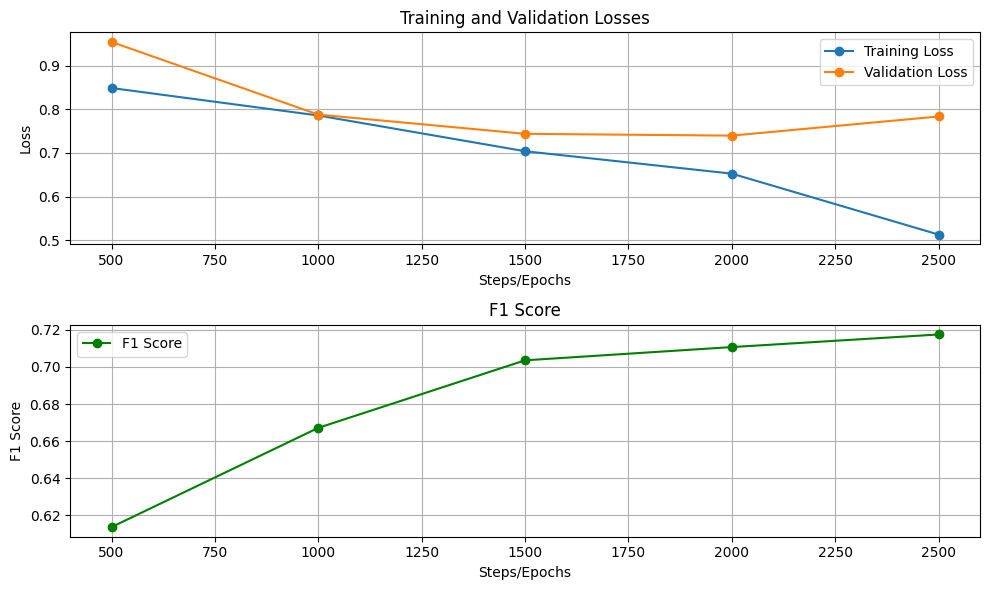

In [109]:


#
steps = [500, 1000, 1500, 2000, 2500]
train_loss = [0.848600, 0.785700, 0.703900, 0.652600, 0.513100]
val_loss = [0.954000, 0.787708, 0.743752, 0.739628, 0.783482]
f1_score = [0.613671, 0.667150, 0.703539, 0.710672, 0.717471]

# Plotting my training and validation losses over steps/epochs

plt.figure(figsize=(10, 6))

##plotting my trianing and validation loss

plt.subplot(2, 1, 1)
plt.plot(steps, train_loss, label='Training Loss', marker='o')
plt.plot(steps, val_loss, label='Validation Loss', marker='o')
plt.xlabel('Steps/Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)

##plotting my f1-score performance

plt.subplot(2, 1, 2)
plt.plot(steps, f1_score, label='F1 Score', marker='o', color='green')
plt.xlabel('Steps/Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()






